# Example for using multiple graph
This notebook demonstrates how to use multiple graph within a LAN.
This experiment utilizes processes as computing nodes.

## 1. Set some global parameters:

In [13]:
if __name__ == "__main__":
    N_STATE = 3
    N_NODES = 5

## 2. Deploy the nodes using multiprocessing:
Here, we use the Laplacian-based consensus iteration formula:
$$
x(k+1) = x(k) - \alpha L x(k).
$$
In this example, we consider two network topologies: **ring** and **star** graphs.

In [14]:
from multiprocessing import Pool
from numpy import float64
from numpy.typing import NDArray


def consensus(
    idx: str, graph_name: str, n_state: int, alpha: float, n_iter: int = 50
) -> NDArray[float64]:
    from numpy import zeros
    from numpy.random import uniform, seed
    from topolink import NodeHandle

    nh = NodeHandle(idx, graph_name, transport="ipc")

    states = zeros((n_iter, n_state))
    seed(int(idx))  # Ensure reproducibility for each node
    states[0] = uniform(-100.0, 100.0, n_state)

    for k in range(n_iter - 1):
        lap_state = nh.laplacian(states[k])
        states[k + 1] = states[k] - lap_state * alpha

    return states


if __name__ == "__main__":
    from logging import basicConfig, INFO

    basicConfig(level=INFO)

    from topolink import Graph, bootstrap

    nodes = ["1", "2", "3", "4", "5"]
    edges = [("1", "2"), ("2", "3"), ("3", "4"), ("4", "5"), ("5", "1")]

    ring = Graph(nodes, edges, name="ring", transport="ipc")

    nodes = ["1", "2", "3", "4", "5"]
    edges = [("1", "2"), ("1", "3"), ("1", "4"), ("1", "5")]

    star = Graph(nodes, edges, name="star", transport="ipc")

    bootstrap(ring, star)

    with Pool(2 * N_NODES + 1) as pool:
        ring_tasks = [
            pool.apply_async(consensus, args=(str(i + 1), "ring", N_STATE, 0.35))
            for i in range(N_NODES)
        ]
        star_tasks = [
            pool.apply_async(consensus, args=(str(i + 1), "star", N_STATE, 0.35))
            for i in range(N_NODES)
        ]

        ring_states = [task.get() for task in ring_tasks]
        star_states = [task.get() for task in star_tasks]

INFO:topolink.graph:Node '2' joined graph 'star' from @topolink-star-2.
INFO:topolink.graph:Node '4' joined graph 'star' from @topolink-star-4.
INFO:topolink.graph:Node '3' joined graph 'ring' from @topolink-ring-3.
INFO:topolink.graph:Node '5' joined graph 'star' from @topolink-star-5.
INFO:topolink.graph:Node '5' joined graph 'ring' from @topolink-ring-5.
INFO:topolink.graph:Node '1' joined graph 'star' from @topolink-star-1.
INFO:topolink.graph:Node '2' joined graph 'ring' from @topolink-ring-2.
INFO:topolink.graph:Node '4' joined graph 'ring' from @topolink-ring-4.
INFO:topolink.graph:Node '3' joined graph 'star' from @topolink-star-3.
INFO:topolink.graph:Graph 'star' registration complete.
INFO:topolink.graph:Sent neighbor info to all nodes in graph 'star'.
INFO:topolink.node_handle:Node '3' joined graph 'star'.
INFO:topolink.node_handle:Node '2' joined graph 'star'.
INFO:topolink.node_handle:Node '4' joined graph 'star'.
INFO:topolink.node_handle:Node '5' joined graph 'star'.
INF

## 3. Plot the results:

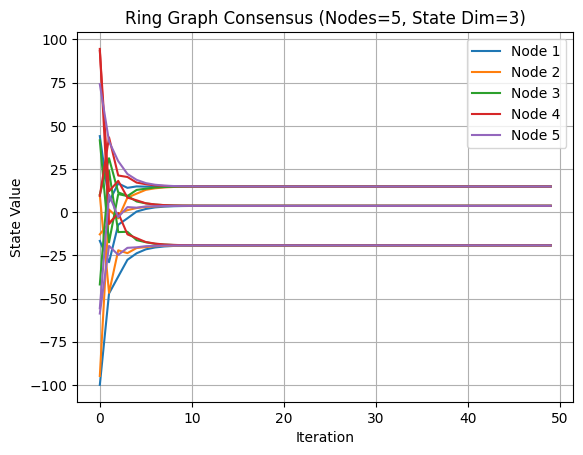

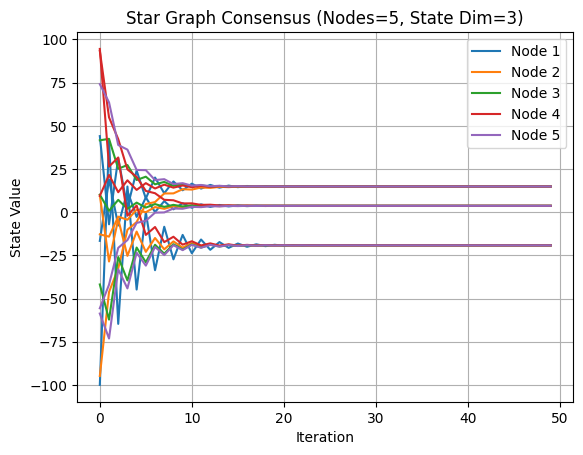

In [ ]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

    _, ax1 = plt.subplots()

    for i in range(N_NODES):
        states = ring_states[i]
        for j in range(N_STATE):
            (line,) = ax1.plot(states[:, j], color=colors[i])
            line.set_label(f"Node {i + 1}") if j == 0 else None

    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("State Value")
    ax1.grid()
    ax1.legend()
    ax1.set_title(f"Ring Graph Consensus (Nodes={N_NODES}, State Dim={N_STATE})")

    _, ax2 = plt.subplots()

    for i in range(N_NODES):
        states = star_states[i]
        for j in range(N_STATE):
            (line,) = ax2.plot(states[:, j], color=colors[i])
            line.set_label(f"Node {i + 1}") if j == 0 else None

    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("State Value")
    ax2.grid()
    ax2.legend()
    ax2.set_title(f"Star Graph Consensus (Nodes={N_NODES}, State Dim={N_STATE})")